# Simulations

### Basic strategy: 

Total available trades: 158
Date range: 2025-02-05 to 2025-03-13

Total trades executed: 87

Performance Analysis:

Performance by Trade Size:
               Avg Return  Count   Win Rate
size_category                              
Small            0.686207     29  55.172414
Medium           1.459655     29  48.275862
Large            0.536552     29  48.275862

Performance by Filing Hour:
             Avg Return  Count    Win Rate
filing_hour                               
9              7.155000      2   50.000000
20             6.373750      8   75.000000
7              3.570000      1  100.000000
21             3.471667      6   83.333333
14             2.640000      1  100.000000
12             2.290000      1  100.000000
19             2.145833     12   50.000000
17             0.845294     17   70.588235
15             0.620000      1  100.000000
16            -1.388333     24   29.166667
8             -1.450000      1    0.000000
18            -1.754615     13   23.076923


C:\Users\Albert\AppData\Local\Temp\ipykernel_1768\4076106489.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_performance = trades_df.groupby('size_category')['return'].agg(['mean', 'count', lambda x: (x > 0).mean() * 100])
C:\Users\Albert\AppData\Local\Temp\ipykernel_1768\4076106489.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_returns = trades_df.groupby('size_category')['return'].mean()



Portfolio Performance Metrics:
Simulation Period: 36 days
Starting Capital: $100.00
Ending Capital: $188.44
Total Return: 88.44%
Number of Trades: 87
Win Rate: 50.57%
Average Return per Trade: 0.89%
Average Trades per Day: 2.42

Annualized Performance (if returns repeatable):
Average Daily Return: 1.78%
Average Monthly Return: 69.56%
Average Annual Return: 61563.17%
Sharpe Ratio: 7.17


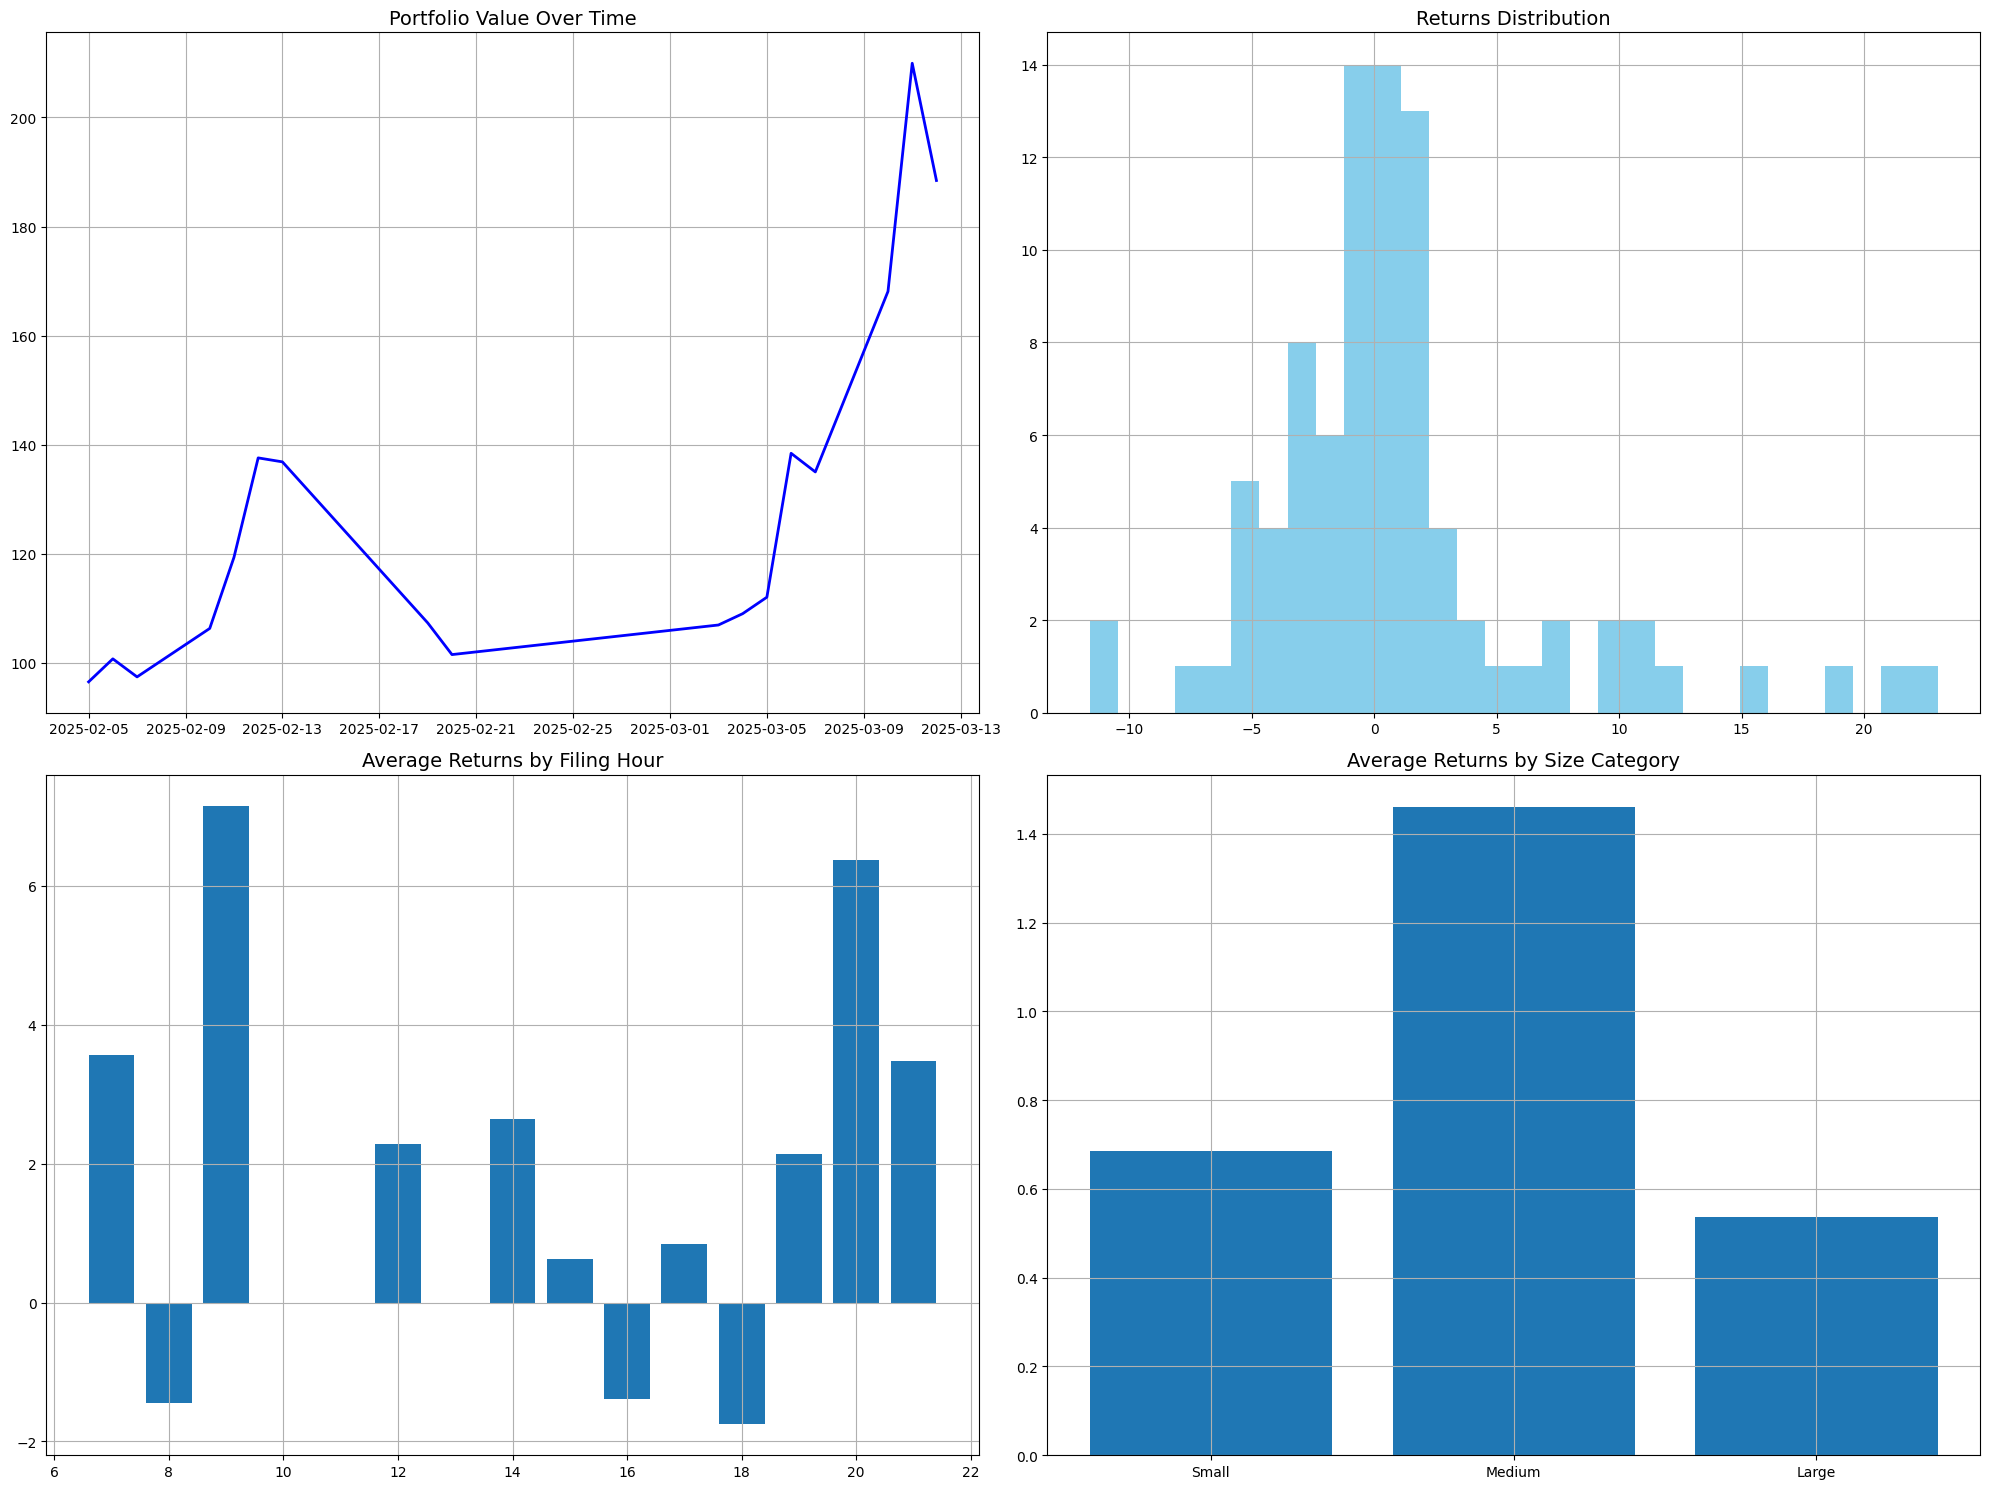

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

def simulate_portfolio_v6():
    # Read and prepare data
    df = pd.read_csv('Scraping/insider_buys_analysis.csv')
    df['Filing Date'] = pd.to_datetime(df['Filing Date'])
    
    def convert_percentage(x):
        if pd.isna(x):
            return None
        return float(str(x).strip('%').replace('+', ''))
    
    df['24h_Change_num'] = df['24h_Change_%'].apply(convert_percentage)
    df['Filing_Hour'] = df['Filing Date'].dt.hour
    
    # Sort by filing date
    df = df.sort_values('Filing Date')
    
    # Initialize portfolio
    initial_capital = 100
    portfolio_value = initial_capital
    portfolio_history = []
    trades_made = []
    
    current_positions = []
    current_date = None
    
    # Track simulation period
    start_date = df['Filing Date'].min()
    end_date = df['Filing Date'].max()
    days_simulated = (end_date - start_date).days
    
    # Print initial data check
    print(f"Total available trades: {len(df)}")
    print(f"Date range: {start_date.date()} to {end_date.date()}")
    
    # Simulate trading day by day
    for idx, row in df.iterrows():
        date = row['Filing Date'].date()
        
        # Close positions from previous day
        if current_date is not None and date != current_date:
            day_return = 0
            for position in current_positions:
                if not pd.isna(position['return']):
                    position_return = position['return']/100
                    portfolio_value *= (1 + position_return)
                    day_return += position_return
            
            if current_positions:
                daily_return = day_return / len(current_positions)
                portfolio_history.append({
                    'date': current_date,
                    'value': portfolio_value,
                    'trades': len(current_positions),
                    'daily_return': daily_return
                })
            
            current_positions = []
        
        current_date = date
        
        # Take all valid trades
        if not pd.isna(row['24h_Change_num']):
            current_positions.append({
                'ticker': row['Ticker'],
                'return': row['24h_Change_num'],
                'value': row['Value'],
                'filing_hour': row['Filing_Hour']
            })
            
            trades_made.append({
                'date': date,
                'ticker': row['Ticker'],
                'return': row['24h_Change_num'],
                'value': row['Value'],
                'filing_hour': row['Filing_Hour']
            })
    
    # Handle final positions
    if current_positions:
        day_return = 0
        for position in current_positions:
            if not pd.isna(position['return']):
                position_return = position['return']/100
                portfolio_value *= (1 + position_return)
                day_return += position_return
        
        daily_return = day_return / len(current_positions)
        portfolio_history.append({
            'date': current_date,
            'value': portfolio_value,
            'trades': len(current_positions),
            'daily_return': daily_return
        })
    
    # Convert to DataFrame for analysis
    portfolio_df = pd.DataFrame(portfolio_history)
    trades_df = pd.DataFrame(trades_made)
    
    print(f"\nTotal trades executed: {len(trades_df)}")
    
    if len(trades_df) == 0:
        print("No trades were executed.")
        return None, None
    
    # Performance metrics
    total_return = ((portfolio_value - initial_capital) / initial_capital) * 100
    num_trades = len(trades_df)
    win_rate = (trades_df['return'] > 0).mean() * 100 if not trades_df.empty else 0
    avg_return_per_trade = trades_df['return'].mean() if not trades_df.empty else 0
    
    # Analyze trade performance by various factors
    print("\nPerformance Analysis:")
    
    # By trade size
    trades_df['size_category'] = pd.qcut(trades_df['value'], q=3, labels=['Small', 'Medium', 'Large'])
    size_performance = trades_df.groupby('size_category')['return'].agg(['mean', 'count', lambda x: (x > 0).mean() * 100])
    size_performance.columns = ['Avg Return', 'Count', 'Win Rate']
    print("\nPerformance by Trade Size:")
    print(size_performance)
    
    # By hour
    hour_performance = trades_df.groupby('filing_hour')['return'].agg(['mean', 'count', lambda x: (x > 0).mean() * 100])
    hour_performance.columns = ['Avg Return', 'Count', 'Win Rate']
    print("\nPerformance by Filing Hour:")
    print(hour_performance.sort_values('Avg Return', ascending=False))
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Portfolio Value
    axes[0,0].plot(portfolio_df['date'], portfolio_df['value'], 'b-', linewidth=2)
    axes[0,0].set_title('Portfolio Value Over Time', fontsize=14)
    axes[0,0].grid(True)
    
    # Returns Distribution
    axes[0,1].hist(trades_df['return'], bins=30, color='skyblue')
    axes[0,1].set_title('Returns Distribution', fontsize=14)
    axes[0,1].grid(True)
    
    # Returns by Hour
    hour_returns = trades_df.groupby('filing_hour')['return'].mean()
    axes[1,0].bar(hour_returns.index, hour_returns.values)
    axes[1,0].set_title('Average Returns by Filing Hour', fontsize=14)
    axes[1,0].grid(True)
    
    # Returns by Size Category
    size_returns = trades_df.groupby('size_category')['return'].mean()
    axes[1,1].bar(size_returns.index, size_returns.values)
    axes[1,1].set_title('Average Returns by Size Category', fontsize=14)
    axes[1,1].grid(True)
    
    plt.tight_layout()
    
    # Print performance metrics
    print("\nPortfolio Performance Metrics:")
    print(f"Simulation Period: {days_simulated} days")
    print(f"Starting Capital: ${initial_capital:.2f}")
    print(f"Ending Capital: ${portfolio_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Number of Trades: {num_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Average Return per Trade: {avg_return_per_trade:.2f}%")
    print(f"Average Trades per Day: {num_trades/days_simulated:.2f}")
    
    # Calculate returns over different time periods
    days_simulated = (end_date - start_date).days
    if days_simulated > 0:
        daily_return = ((portfolio_value / initial_capital) ** (1/days_simulated) - 1) * 100
        monthly_return = ((1 + daily_return/100) ** 30 - 1) * 100
        annual_return = ((1 + daily_return/100) ** 365 - 1) * 100
        
        print("\nAnnualized Performance (if returns repeatable):")
        print(f"Average Daily Return: {daily_return:.2f}%")
        print(f"Average Monthly Return: {monthly_return:.2f}%")
        print(f"Average Annual Return: {annual_return:.2f}%")
        
        # Calculate Sharpe Ratio (assuming risk-free rate of 2%)
        if len(portfolio_df) > 1:
            daily_returns = portfolio_df['daily_return']
            excess_returns = daily_returns - 0.02/365  # Daily risk-free rate
            sharpe_ratio = np.sqrt(365) * excess_returns.mean() / excess_returns.std()
            print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    
    return portfolio_df, trades_df

# Run the simulation
portfolio_df, trades_df = simulate_portfolio_v6()